<center><img src="/images/graphsage/thumbnail.jpg"></center>

::: {.column-margin}
Find a lot more architectures and applications using graph neural networks in my book, [**Hands-On Graph Neural Networks**](https://mlabonne.github.io/blog/book.html) 👇
<a href="https://packt.link/a/9781804617526"><img src="/images/gnnbook/cover.png" alt="Hands-On Graph Neural Networks Using Python" id="gnn-book"></a>
:::

What do UberEats and Pinterest have in common?

They both use GraphSAGE to power their recommender systems on a massive scale: millions and billions of nodes and edges.

* 🖼️ **Pinterest** developed its own version called [PinSAGE](https://medium.com/pinterest-engineering/pinsage-a-new-graph-convolutional-neural-network-for-web-scale-recommender-systems-88795a107f48) to recommend the most relevant images (pins) to its users. Their graph has 18 billion connections and three billion nodes.
* 🍽️ **UberEats** also reported using a [modified version of GraphSAGE](https://eng.uber.com/uber-eats-graph-learning/) to suggest dishes, restaurants, and cuisines. UberEats claims to support more than 600,000 restaurants and 66 million users. Meanwhile, it keeps recommending me tacos that gave me food poisoning.

In this tutorial, we'll use a dataset with 20k nodes instead of billions because Google Colab cannot handle our ambitions. We will stick to the original GraphSAGE architecture, but the previous variants also bring exciting features we will discuss.

You can run the code with the following [Google Colab notebook](https://colab.research.google.com/drive/1udeUfWJzvMlLO7sGUDGsHo8cRPMicajl?usp=sharing).

In [ ]:
# Install PyTorch Geometric
import torch
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Visualization
import networkx as nx
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.size': 24})

## 🌐 I. PubMed dataset

<center><img src="/images/graphsage/pubmed.png"></center>

As we saw in the [previous article](https://mlabonne.github.io/blog/gat/), PubMed is part of the Planetoid dataset (MIT license). Here's a quick summary:

* It contains **19,717 scientific publications** about diabetes from PubMed's database
* Node features are **[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) weighted word vectors** with 500 dimensions, which is an efficient way of summarizing documents without transformers
* The task is quite straightforward since it's a multi-class classification with **three categories**: diabetes mellitus experimental, diabetes mellitus type 1, and diabetes mellitus type 2

Let's load the dataset and print some information about the graph.

In [5]:
from torch_geometric.datasets import Planetoid

dataset = Planetoid(root='.', name="Pubmed")
data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Training nodes: {sum(data.train_mask).item()}')
print(f'Evaluation nodes: {sum(data.val_mask).item()}')
print(f'Test nodes: {sum(data.test_mask).item()}')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Dataset: Pubmed()
-------------------
Number of graphs: 1
Number of nodes: 19717
Number of features: 500
Number of classes: 3

Graph:
------
Training nodes: 60
Evaluation nodes: 500
Test nodes: 1000
Edges are directed: False
Graph has isolated nodes: False
Graph has loops: False


As we can see, PubMed has an insanely low number of training nodes compared to the whole graph. There are only 60 samples to learn how to classify the 1000 test nodes.

Despite this challenge, GNNs manage to obtain high levels of accuracy. Here's the leaderboard of known techniques (a more exhaustive benchmark can be found on [PapersWithCode](https://paperswithcode.com/sota/node-classification-on-pubmed)):

| Model | 📝PubMed (accuracy) |
| :--- | :---: |
| Multilayer Perceptron | 71.4% |
| Graph Convolutional Network | **79.0%** ± 0.3% |
| Graph Attention Network | **79.0%** ± 0.3% |
| GraphSAGE | **???** |

I couldn't find any result for GraphSAGE on PubMed with this specific setting (60 training nodes, 1000 test nodes), so I don't expect a great accuracy. But another metric can be just as relevant when working with large graphs: **training time**.

## 🧙‍♂️ II. GraphSAGE in theory

<center><img src="/images/graphsage/architecture.png"></center>

The **GraphSAGE** algorithm can be divided into two steps:

1. **Neighbor sampling**;
2. **Aggregation**.

### 🎰 A. Neighbor sampling 

Neighbor sampling relies on a classic technique used to train neural networks: mini-batch gradient descent.

Mini-batch gradient descent works by breaking down a dataset into smaller batches. During training, we compute the gradient for every mini-batch instead of every epoch (batch gradient descent) or every training sample (stochastic gradient descent). Mini-batching has several benefits:

1. **Improved accuracy** — mini-batches help to reduce overfitting (gradients are averaged), as well as variance in error rates
2. **Increased speed** — mini-batches are processed in parallel and take less time to train than larger batches
3. **Improved scalability** — an entire dataset can exceed the GPU memory, but smaller batches can get around this limitation

More advanced optimizes like Adam also rely on mini-batching. However, it is not as straightforward with graph data since splitting the dataset into smaller chunks would break essential connections between nodes.

So, what can we do? In recent years, researchers developed different strategies to create graph mini-batches. The one we're interested in is called [**neighbor sampling**](https://arxiv.org/abs/1706.02216)). There are many other techniques you can find on [PyG's documentation](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html), such as [subgraph clustering](https://arxiv.org/pdf/1905.07953.pdf)).

<video autoplay loop muted width="800" class="no-margin">
    <source src="https://github.com/mlabonne/blog/raw/master/images/graphsage/sampling.mp4" type="video/mp4"></source>
</video>

Neighbor sampling considers only a fixed number of random neighbors. Here's the process:

1. The sampler **randomly selects** a defined number of neighbors (1 hop), neighbors of neighbors (2 hops), etc. we would like to have
2. The sampler **outputs a subgraph** containing the target and sampled nodes

This process is repeated for every node in a list or the entirety of the graph. However, creating a subgraph for each node is not efficient, which is why we can process them in batches instead. In this case, each subgraph is shared by multiple target nodes.

Neighbor sampling has an added benefit. Sometimes, we observe extremely popular nodes that act like hubs, such as celebrities on social media. Calculating embeddings for these nodes can be computationally very expensive since it requires calculating the hidden vectors of thousands or even millions of neighbors. GraphSAGE fixes this issue by only considering a fixed number of neighbors.

In PyG, neighbor sampling is implemented through the [`NeighborLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/loader.html#torch_geometric.loader.NeighborLoader) object. Let's say we want 5 neighbors and 10 of their neighbors (`num_neighbors`). As we discussed, we can also specify a `batch_size` to speed up the process by creating subgraphs for multiple target nodes.

Subgraph 0: Data(x=[389, 500], edge_index=[2, 448], y=[389], train_mask=[389], val_mask=[389], test_mask=[389], batch_size=16)
Subgraph 1: Data(x=[264, 500], edge_index=[2, 314], y=[264], train_mask=[264], val_mask=[264], test_mask=[264], batch_size=16)
Subgraph 2: Data(x=[283, 500], edge_index=[2, 330], y=[283], train_mask=[283], val_mask=[283], test_mask=[283], batch_size=16)
Subgraph 3: Data(x=[189, 500], edge_index=[2, 229], y=[189], train_mask=[189], val_mask=[189], test_mask=[189], batch_size=12)


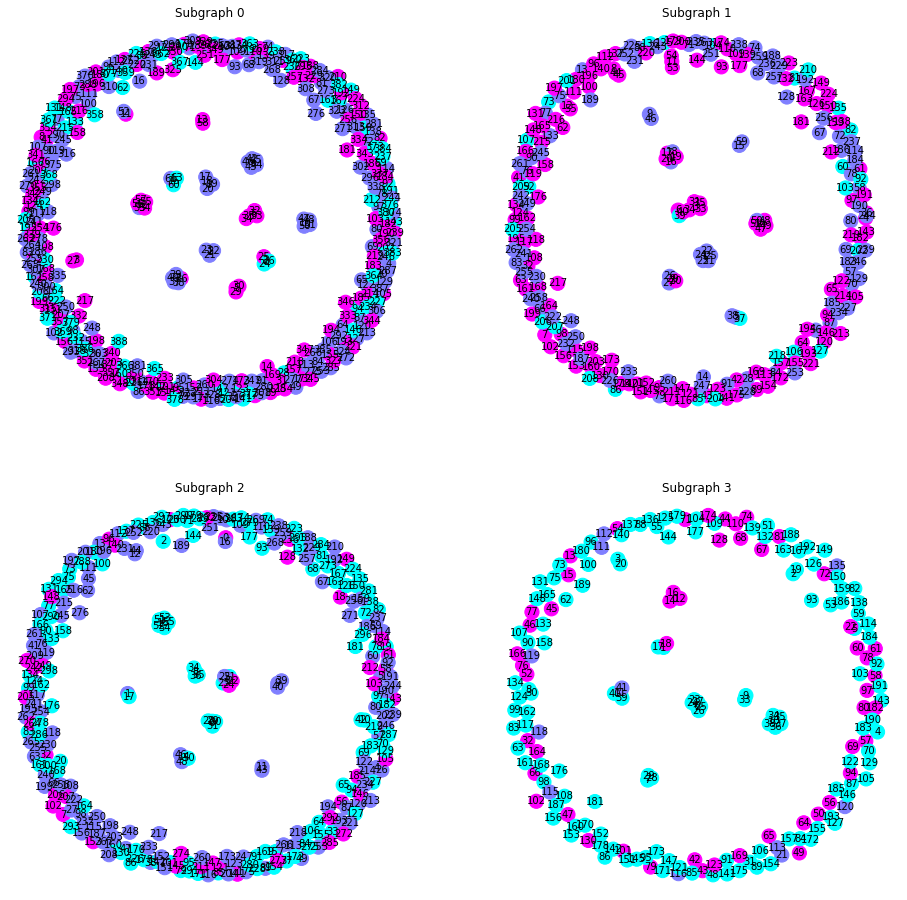

In [ ]:
from torch_geometric.loader import NeighborLoader
from torch_geometric.utils import to_networkx

# Create batches with neighbor sampling
train_loader = NeighborLoader(
    data,
    num_neighbors=[5, 10],
    batch_size=16,
    input_nodes=data.train_mask,
)

# Print each subgraph
for i, subgraph in enumerate(train_loader):
    print(f'Subgraph {i}: {subgraph}')

# Plot each subgraph
fig = plt.figure(figsize=(16,16))
for idx, (subdata, pos) in enumerate(zip(train_loader, [221, 222, 223, 224])):
    G = to_networkx(subdata, to_undirected=True)
    ax = fig.add_subplot(pos)
    ax.set_title(f'Subgraph {idx}')
    plt.axis('off')
    nx.draw_networkx(G,
                    pos=nx.spring_layout(G, seed=0),
                    with_labels=True,
                    node_size=200,
                    node_color=subdata.y,
                    cmap="cool",
                    font_size=10
                    )
plt.show()

We created four subgraphs of various sizes. It allows us to process them in parallel and they're easier to fit on a GPU since they're smaller.

The number of neighbors is an important parameter since pruning our graph removes a lot of information. How much, exactly? Well, quite a lot. We can visualize this effect by looking at the **node degrees** (number of neighbors).

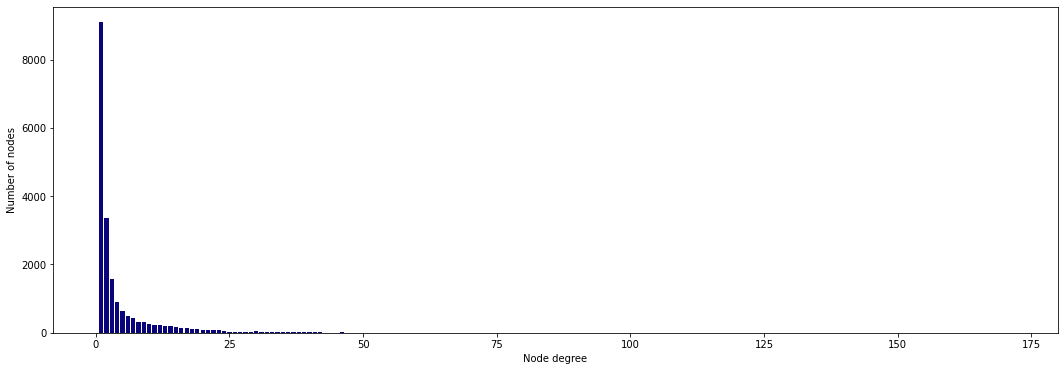

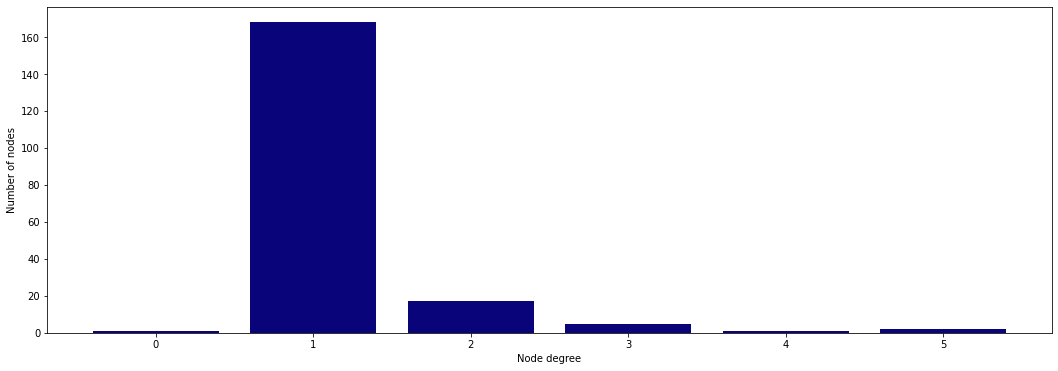

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

def plot_degree(data):
    # Get list of degrees for each node
    degrees = degree(data.edge_index[0]).numpy()

    # Count the number of nodes for each degree
    numbers = Counter(degrees)

    # Bar plot
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.set_xlabel('Node degree')
    ax.set_ylabel('Number of nodes')
    plt.bar(numbers.keys(),
            numbers.values(),
            color='#0A047A')

# Plot node degrees from the original graph
plot_degree(data)

# Plot node degrees from the last subgraph
plot_degree(subdata)

The first plot shows the original distribution of node degrees, and the second one shows the distribution we obtain after neighbor sampling. In this example, we chose to only consider five neighbors, which is much lower than the original maximal value. It's important to remember this tradeoff when talking about GraphSAGE.

PinSAGE proposes another solution. Instead of neighbor sampling, PinSAGE simulates random walks for each node, which captures a better representation of their neighborhoods. Then, it selects a predefined number of neighbors with the highest visit counts. This technique allows PinSAGE to consider the importance of each neighbor while controlling the size of the computation graph.

### 💥 B. Aggregation

The aggregation process determines how to combine the feature vectors to produce the node embeddings. The original paper presents three ways of aggregating features:

* **Mean** aggregator
* **LSTM** aggregator
* **Pooling** aggregator

<video autoplay loop muted width="800" class="no-margin">
    <source src="https://github.com/mlabonne/blog/raw/master/images/graphsage/aggregation.mp4" type="video/mp4"></source>
</video>

The **mean aggregator** is the simplest one. The idea is close to a GCN approach:

1. The hidden features of the target node and its selected neighbors are averaged (nodes in $\mathcal{\tilde{N}}_i$).
2. A linear transformation with a weight matrix $\textbf{W}$ is applied.

In other words, we can write:

$$\textbf{h}_i' = \textbf{W} \cdot mean_{j \in \mathcal{\tilde{N}}_i}(\textbf{h}_j)$$

The result can then be fed to a nonlinear activation function like ReLU.

The **LSTM aggregator** may seem counter-intuitive because this architecture is sequential: it assigns an order to our unordered nodes. This is why the authors randomly shuffle them to force the LSTM only to consider the hidden features. Nevertheless, it is the best-performing technique in their benchmarks.

The **pooling aggregator** feeds each neighbor's hidden vector to a feedforward neural network. Then, an elementwise max operation is applied to the result to keep the highest value for each feature.

## 🧠 III. GraphSAGE in PyTorch Geometric

We can easily implement a GraphSAGE architecture in PyTorch Geometric with the `SAGEConv` layer. This implementation uses two weight matrices instead of one, like UberEats' version of GraphSAGE:

$$\textbf{h}_i' = \textbf{W}_1\textbf{h}_i + \textbf{W}_2 \cdot mean_{j \in \mathcal{N}_i}(\textbf{h}_j)$$

Let's create a network with two `SAGEConv` layers:

* The first one uses $ReLU$ as the activation function and a **dropout layer**;
* The second one directly outputs the **node embeddings**.

As we're dealing with a multi-class classification task, we'll use the cross-entropy loss as our loss function. I also added an L2 regularization of 0.0005 for good measure.

To see the benefits of GraphSAGE, let's compare it with a GCN and a GAT without any sampling.

In [ ]:
import torch
from torch.nn import Linear, Dropout
from torch_geometric.nn import SAGEConv, GATv2Conv, GCNConv
import torch.nn.functional as F


class GraphSAGE(torch.nn.Module):
  """GraphSAGE"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.sage1 = SAGEConv(dim_in, dim_h)
    self.sage2 = SAGEConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = self.sage1(x, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.sage2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
      total_loss = 0
      acc = 0
      val_loss = 0
      val_acc = 0

      # Train on batches
      for batch in train_loader:
        optimizer.zero_grad()
        out = self(batch.x, batch.edge_index)
        loss = criterion(out[batch.train_mask], batch.y[batch.train_mask])
        total_loss += loss
        acc += accuracy(out[batch.train_mask].argmax(dim=1), 
                        batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss += criterion(out[batch.val_mask], batch.y[batch.val_mask])
        val_acc += accuracy(out[batch.val_mask].argmax(dim=1), 
                            batch.y[batch.val_mask])

      # Print metrics every 10 epochs
      if(epoch % 10 == 0):
          print(f'Epoch {epoch:>3} | Train Loss: {total_loss/len(train_loader):.3f} '
                f'| Train Acc: {acc/len(train_loader)*100:>6.2f}% | Val Loss: '
                f'{val_loss/len(train_loader):.2f} | Val Acc: '
                f'{val_acc/len(train_loader)*100:.2f}%')

class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=heads)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index).relu()
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return F.log_softmax(h, dim=1)

  def fit(self, data, epochs):
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = self.optimizer

    self.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        out = self(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1),
                       data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1),
                           data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc:'
                  f' {acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
            
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

@torch.no_grad()
def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

With GraphSAGE, we loop through **batches** (our four subgraphs) created by the neighbor sampling process. The way we calculate the accuracy and the validation loss is also different because of that.

In [ ]:
%%time

# Create GraphSAGE
graphsage = GraphSAGE(dataset.num_features, 64, dataset.num_classes)
print(graphsage)

# Train
graphsage.fit(data, 200)

# Test
print(f'\nGraphSAGE test accuracy: {test(graphsage, data)*100:.2f}%\n')

GraphSAGE(
  (sage1): SAGEConv(500, 64)
  (sage2): SAGEConv(64, 3)
)
Epoch   0 | Train Loss: 0.332 | Train Acc:  30.24% | Val Loss: 1.13 | Val Acc: 18.33%
Epoch  10 | Train Loss: 0.020 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 72.50%
Epoch  20 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 73.17%
Epoch  30 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 0.49 | Val Acc: 79.96%
Epoch  40 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 63.33%
Epoch  50 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 0.61 | Val Acc: 75.56%
Epoch  60 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.77 | Val Acc: 71.25%
Epoch  70 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.50 | Val Acc: 79.79%
Epoch  80 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 0.54 | Val Acc: 76.74%
Epoch  90 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.65 | Val Acc: 76.74%
Epoch 100 | Train Loss: 0.002 | Train Acc: 100.00% | Val Loss: 0.49 | V

In [ ]:
%%time

# Create GCN
gcn = GCN(dataset.num_features, 64, dataset.num_classes)
print(gcn)

# Train
gcn.fit(data, 200)

# Test
print(f'\nGCN test accuracy: {test(gcn, data)*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(500, 64)
  (gcn2): GCNConv(64, 3)
)
Epoch   0 | Train Loss: 1.098 | Train Acc:  33.33% | Val Loss: 1.10 | Val Acc: 32.20%
Epoch  10 | Train Loss: 0.736 | Train Acc:  91.67% | Val Loss: 0.87 | Val Acc: 74.60%
Epoch  20 | Train Loss: 0.400 | Train Acc:  96.67% | Val Loss: 0.67 | Val Acc: 73.80%
Epoch  30 | Train Loss: 0.214 | Train Acc:  93.33% | Val Loss: 0.61 | Val Acc: 76.80%
Epoch  40 | Train Loss: 0.124 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 75.60%
Epoch  50 | Train Loss: 0.092 | Train Acc: 100.00% | Val Loss: 0.62 | Val Acc: 77.20%
Epoch  60 | Train Loss: 0.095 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 76.80%
Epoch  70 | Train Loss: 0.087 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.20%
Epoch  80 | Train Loss: 0.085 | Train Acc: 100.00% | Val Loss: 0.63 | Val Acc: 75.60%
Epoch  90 | Train Loss: 0.088 | Train Acc:  98.33% | Val Loss: 0.62 | Val Acc: 76.60%
Epoch 100 | Train Loss: 0.074 | Train Acc:  98.33% | Val Loss: 0.63 | Val Acc: 75

In [ ]:
%%time

# Create GAT
gat = GAT(dataset.num_features, 64, dataset.num_classes)
print(gat)

# Train
gat.fit(data, 200)

# Test
print(f'\nGAT test accuracy: {test(gat, data)*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(500, 64, heads=8)
  (gat2): GATv2Conv(512, 3, heads=8)
)
Epoch   0 | Train Loss: 3.174 | Train Acc:   1.67% | Val Loss: 3.18 | Val Acc: 1.00%
Epoch  10 | Train Loss: 0.707 | Train Acc:  86.67% | Val Loss: 0.87 | Val Acc: 71.00%
Epoch  20 | Train Loss: 0.363 | Train Acc:  93.33% | Val Loss: 0.64 | Val Acc: 77.20%
Epoch  30 | Train Loss: 0.178 | Train Acc:  96.67% | Val Loss: 0.58 | Val Acc: 78.40%
Epoch  40 | Train Loss: 0.101 | Train Acc: 100.00% | Val Loss: 0.56 | Val Acc: 78.40%
Epoch  50 | Train Loss: 0.087 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 77.80%
Epoch  60 | Train Loss: 0.072 | Train Acc: 100.00% | Val Loss: 0.57 | Val Acc: 78.40%
Epoch  70 | Train Loss: 0.076 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.40%
Epoch  80 | Train Loss: 0.064 | Train Acc: 100.00% | Val Loss: 0.59 | Val Acc: 76.40%
Epoch  90 | Train Loss: 0.058 | Train Acc: 100.00% | Val Loss: 0.58 | Val Acc: 77.20%
Epoch 100 | Train Loss: 0.062 | Train Acc: 100.00% | Val Lo

The three models obtain similar results in terms of accuracy. We expect the GAT to perform better because its aggregation mechanism is more nuanced, but it's not always the case.

The real difference is the training time: GraphSAGE is **88 times faster** than the GAT and four times faster than the GCN in this example!

This is the true benefit of GraphSAGE. While it loses a lot of information by pruning the graph with neighbor sampling, it greatly improves scalability. In turn, it can lead to building larger graphs that can improve accuracy.

<center><img src="/images/graphsage/timechart.png" width="800"></center>

GraphSAGE is a popular framework with many flavors.

In this example, we have used GraphSAGE in a **transductive** setting. We masked information about test nodes during training, but we didn't hide their presence in the adjacency matrix. On the contrary, in an **inductive** setting, the test set is never encountered during training.

This difference is essential: an inductive model can calculate embeddings for nodes that have never been seen before. On the other hand, a transductive model has to be re-trained, which can quickly become computationally costly. Thanks to neighbor sampling, GraphSAGE is designed to be an inductive model: it does not require seeing every neighbor to calculate an embedding.

Besides these two settings, GraphSAGE can be trained in an **unsupervised** way. In this case, we can't use the cross-entropy loss. We have to engineer a loss function that forces nodes that are nearby in the original graph to remain close to each other in the embedding space. Conversely, the same function must ensure that distant nodes in the graph must have distant representations in the embedding space. This is the loss that is presented in [GraphSAGE's paper](https://cs.stanford.edu/people/jure/pubs/graphsage-nips17.pdf).

PinSAGE and UberEeats' modified GraphSAGE are also slightly different since we're dealing with **recommender systems**. Their goal is to correctly rank the most relevant items (pins, restaurants) for each user. We don't only want to get the closest embeddings, but we also have to produce the best rankings possible. This is why these systems are trained in an unsupervised way but with another loss function: a max-margin ranking loss.

## Conclusion

GraphSAGE is an incredibly fast architecture that can process large graphs. It might not be as accurate as a GCN or a GAT, but it is an essential model for handling massive amounts of data. It delivers this speed thanks to a clever combination of neighbor sampling and fast aggregation. In this article,

* We explored a new dataset with PubMed, which has almost ten times more connections than the previous one (CiteSeer)
* We explained the idea behind neighbor sampling, which only considers a predefined number of random neighbors at each hop
* We saw the three aggregators presented in GraphSAGE's paper and focused on the mean aggregator
* We benchmarked three models (GraphSAGE, GAT, and GCN) in terms of accuracy and training time

We saw three architectures with the same end application: node classification. But GNNs have been successfully applied to other tasks. In the next tutorials, I'd like to use them in two different contexts: graph and edge prediction. This will be a good way to discover new datasets and applications where GNNs dominate the state of the art.

If you enjoyed this article, let's connect on Twitter [@maximelabonne](https://twitter.com/maximelabonne) for more graph learning content.

Thanks for your attention! 📣

## 🌐 Graph Neural Network Course

<a href="https://github.com/mlabonne/Graph-Neural-Network-Course" class="related">🔎 Course overview</a>

<a href="https://mlabonne.github.io/blog/intrognn/" class="related">📝 Chapter 1: Introduction to Graph Neural Networks</a>

<a href="https://mlabonne.github.io/blog/gat/" class="related">📝 Chapter 2: Graph Attention Network</a>

<a href="https://mlabonne.github.io/blog/graphsage/" class="related">📝 Chapter 3: GraphSAGE</a>

<a href="https://mlabonne.github.io/blog/gin/" class="related">📝 Chapter 4: Graph Isomorphism Network</a>